In [28]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from eval_util import make_compare_plot,plot_cdf,plot_pdf,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering,convert_type
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline

In [4]:
def plot_pdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)

    plt.plot(bins_count[1:], pdf, label=label)
    ax = plt.gca()
#     ax.get_yaxis().set_visible(False)
#     ax.get_xaxis().set_visible(False)
    plt.xticks(color='w')
    plt.yticks(color = "w")

def plot_cdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label=label)
    ax = plt.gca()
#     ax.get_yaxis().set_visible(False)
#     ax.get_xaxis().set_visible(False)
    plt.xticks(color='w')
    plt.yticks(color = "w")

    
    
def count_cdf(data,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count, cdf
    
    
    
def make_compare_plot(datasets,col_name, function, names, title, dataset, additional=""):
    for i in range(len(datasets)):
        data = datasets[i]
        function(data[col_name],names[i])
    #plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig("evaluation_result/{}/{}_{}.png".format(dataset,title,additional))
    plt.show()


In [29]:
dataname = "adult"
datapath = "dataset"
generated = "{}/generated/{}/".format(datapath,dataname)


data_origin = pd.read_csv("{}/origin/{}.csv".format(datapath,dataname))

#datalist = ["ctgan","tablegan","octgan","VAE","KL_daisy","sel_daisy","sm_daisy","selgan"]


ctgan = pd.read_csv("{}/generated/{}/ctgan/ctgan_less_150.csv".format(datapath,dataname))

if (dataname =="adult") or  (dataname =="credit"):
    tablegan = pd.read_csv("{}/generated/{}/tablegan/tablegan_{}_fake.csv".format(datapath,dataname,dataname))

if not dataname == "ticket":
    octgan = pd.read_csv("{}/generated/{}/octgan/octgan_{}_less.csv".format(datapath,dataname,dataname))
    
VAE = pd.read_csv("{}/generated/{}/VAE/sample_data_vae_800_0.csv".format(datapath,dataname,dataname)).set_axis(data_origin.columns, axis=1, inplace=False)
#VAE = pd.read_csv("{}/generated/{}/ctgan/tvae_200.csv".format(datapath,dataname))


selgan = pd.read_csv("{}/generated/{}/selgan/selgan_300_full_batch.csv".format(datapath,dataname))


KL_daisy = pd.read_csv("{}/generated/{}/KL/KL_1_800_0.csv".format(datapath,dataname,dataname))
sel_daisy = pd.read_csv("{}/generated/{}/sel/sel_1_800_0.csv".format(datapath,dataname,dataname))
sm_daisy = pd.read_csv("{}/generated/{}/sel_mean/sel_mean_1_800_0.csv".format(datapath,dataname,dataname))



In [3]:
save_path = "evaluation_result/{}".format(dataname)
try:
    os.mkdir(save_path)
except:
    pass

In [4]:
data_origin.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [5]:
def mode_collapse(datalist,namelist):
    for i in range(len(datalist)):
        data = datalist[i]
        name = namelist[i]
        print(name, (data.shape[0] - data.drop_duplicates().shape[0])/(data.shape[0])*100)

In [281]:
mode_collapse([ctgan,selgan,octgan,tablegan,VAE],["ctgan","selgan","octgan","tablegan","VAE"])

ctgan 0.0
selgan 0.0
octgan 0.0
tablegan 3.2
VAE 0.7794878598912034


## Visualization

In [212]:
def twobytwo(datasetleft,datanameleft,datasetright,datanameright,title,column_name):
    
    fig, (axs1,axs2) = plt.subplots(1,2, figsize = (16,9))
    
    for i in range(len(datasetleft)):
        data = datasetleft[i]
        plot_cdf(data[column_name],datanameleft[i],axs1)
        

#     for i in range(len(datanameright)):
#         data = datasetright[i]
#         bins_count, cdf = count_cdf(data[column_name])
#         axs2.plot(bins_count[1:], cdf, label=datanameright[i])
        
    plt.legend()
    plt.grid()
    fig.tight_layout()
        

    plt.show()
    

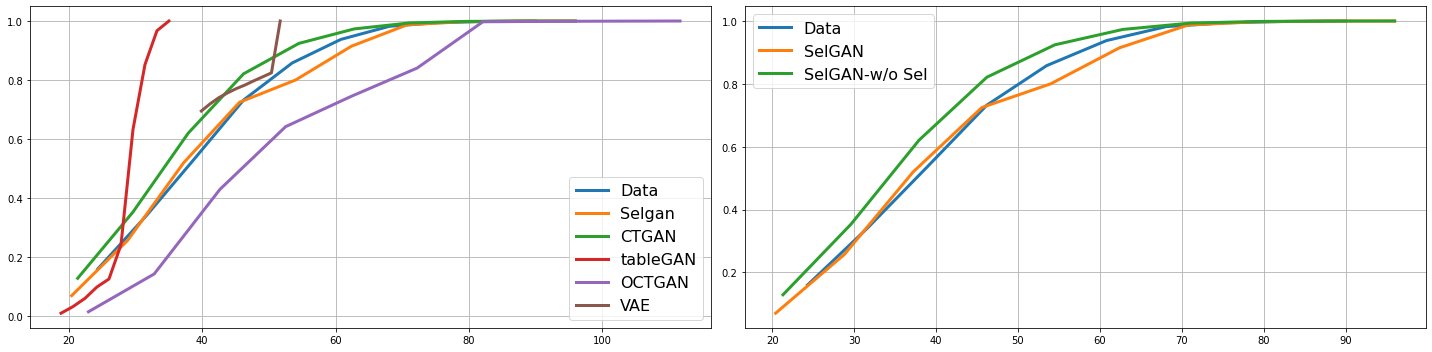

In [306]:
import matplotlib.font_manager as font_manager

column_name = "age"
datasetleft = [data_origin, selgan, ctgan, tablegan, octgan, VAE]
datanameleft = ["Data", "Selgan","CTGAN", "tableGAN", "OCTGAN", "VAE"]
datasetright = [data_origin, selgan, ctgan]
datanameright = ["Data", "SelGAN", "SelGAN-w/o Sel"]

fig, (axs1,axs2) = plt.subplots(1,2, figsize = (20,5))

font = font_manager.FontProperties(
                                   #family='Comic Sans MS',
                                   #weight='bold',
                                   #style='normal', 
                                    size=16)


for i in range(len(datasetleft)):
    data = datasetleft[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs1.plot(bins_count[1:], cdf, label=datanameleft[i],linewidth=3)

for i in range(len(datasetright)):
    data = datasetright[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs2.plot(bins_count[1:], cdf, label=datanameright[i],linewidth=3)
    
axs1.legend(prop=font)
axs1.grid()
axs2.legend(prop=font)
axs2.grid()
fig.tight_layout()
        
    
# plt.subplots_adjust(left=0.1,
#                     bottom = 0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.1)

plt.savefig("evaluation_result/{}/CDF_{}.png".format(dataname,column_name))

In [208]:
def plot_cdf(data,label,axs,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs.plot(bins_count[1:], cdf, label=label)
#     ax = plt.gca()
# #     ax.get_yaxis().set_visible(False)
# #     ax.get_xaxis().set_visible(False)
#     plt.xticks(color='w')
#     plt.yticks(color = "w")
    
    
def make_compare_plot(datasets,col_name, function, names, title, dataset, additional=""):
    for i in range(len(datasets)):
        data = datasets[i]
        plot_cdf(data[col_name],names[i])
    #plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig("evaluation_result/{}/{}_{}.png".format(dataset,title,additional))
    plt.show()

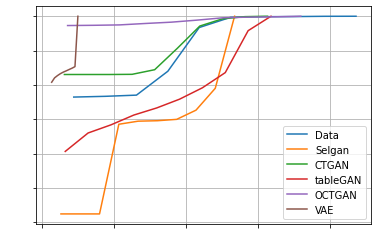

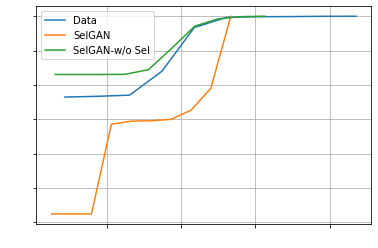

In [113]:
# CDF 可以用
column_name = "capital-loss"

# make_compare_plot([data_origin, ctgan,selgan, tablegan, octgan, VAE],column_name,
# plot_pdf,["Data","ctgan", "selgan", "tablegan", "octgan", "VAE"],"{} PDF Distribution".format(column_name),dataname,"full")
make_compare_plot([data_origin,selgan, ctgan, tablegan, octgan, VAE],column_name,
plot_cdf,["Data", "Selgan","CTGAN", "tableGAN", "OCTGAN", "VAE"],"{} CDF Distribution".format(column_name),dataname,"full")
make_compare_plot([data_origin, selgan, ctgan],column_name,
plot_cdf,["Data", "SelGAN", "SelGAN-w/o Sel"],"{} CDF Distribution".format(column_name),dataname,"selgan")

In [132]:
data_origin.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'label'],
      dtype='object')

In [63]:
#Distance between NMI matrices
dataset = [data_origin, ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]

distance_NMI = {}

from sklearn.metrics.cluster import normalized_mutual_info_score
for col in ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country']:
    
    mylist = []
    for data in dataset:
        A = data_origin[col].sample(n=5000, random_state=1)
        B = data[col].sample(n=5000, random_state=1)
        mylist.append(normalized_mutual_info_score(A,B))
    distance_NMI[col] = mylist
        

In [65]:
distance_NMI_df = pd.DataFrame(distance_NMI,index=["ground_truth",'ctgan','selgan','octgan',"tablegan",'VAE','KL_daisy','sel_daisy','sm_daisy'])
distance_NMI_df.to_csv("evaluation_result/{}/distance_NMI_real.csv".format(dataname),index = False)

In [66]:
distance_NMI_df

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
ground_truth,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ctgan,0.003540,0.010454,0.002205,0.007153,0.001448,0.003187,0.000612,0.037625
selgan,0.002171,0.009743,0.002014,0.009054,0.001554,0.002922,0.000008,0.037840
octgan,0.002910,0.009771,0.002674,0.007039,0.001365,0.003024,0.000299,0.048049
tablegan,0.001300,0.005047,0.001452,0.004442,0.001993,0.003156,0.000125,0.037881
VAE,0.000000,0.002744,0.001939,0.003561,0.001702,0.000000,0.000010,0.000000
KL_daisy,0.003644,0.008397,0.002860,0.007776,0.002448,0.002655,0.000051,0.024968
sel_daisy,0.002450,0.010305,0.001218,0.004445,0.001074,0.001095,0.000034,0.016275
sm_daisy,0.002194,0.007941,0.003495,0.006560,0.002009,0.002974,0.000031,0.016718


In [30]:
distance_NMI_df = pd.DataFrame(distance_NMI,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])
distance_NMI_df.to_csv("evaluation_result/{}/distance_NMI.csv".format(dataname),index = False)

In [31]:
distance_NMI_df

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
ground Truth,0.003540,0.010454,0.002205,0.007153,0.001448,0.003187,0.000612,0.037625
ctgan,0.002171,0.009743,0.002014,0.009054,0.001554,0.002922,0.000008,0.037840
selgan,0.002910,0.009771,0.002674,0.007039,0.001365,0.003024,0.000299,0.048049
octgan,0.001300,0.005047,0.001452,0.004442,0.001993,0.003156,0.000125,0.037881
VAE,0.000000,0.002744,0.001939,0.003561,0.001702,0.000000,0.000010,0.000000
KL_daisy,0.003644,0.008397,0.002860,0.007776,0.002448,0.002655,0.000051,0.024968
sel_daisy,0.002450,0.010305,0.001218,0.004445,0.001074,0.001095,0.000034,0.016275
sm_daisy,0.002194,0.007941,0.003495,0.006560,0.002009,0.002974,0.000031,0.016718


In [307]:
import scipy
import scipy.cluster.hierarchy as sch
import seaborn as sns

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [119]:
VAE = VAE.dropna()

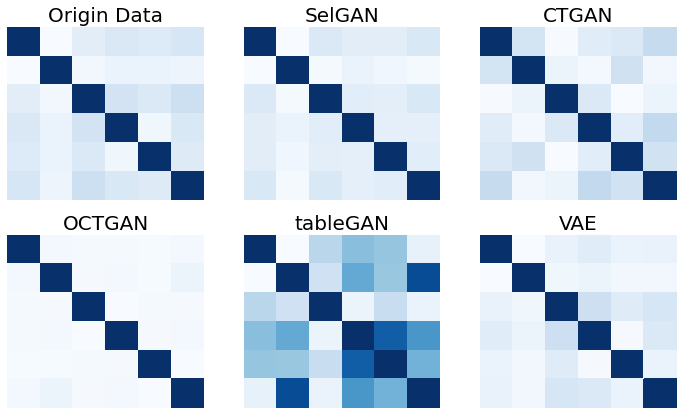

In [323]:
f,axs = plt.subplots(2,3,figsize = (12,7))

sns.heatmap(data_origin.corr(),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,0])
axs[0, 0].set_title('Origin Data', fontsize=20)

sns.heatmap((ctgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,1])
axs[0, 1].set_title('SelGAN', fontsize=20)

sns.heatmap((selgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,2])
axs[0, 2].set_title('CTGAN', fontsize=20)

sns.heatmap((octgan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,0])
axs[1, 0].set_title('OCTGAN', fontsize=20)

sns.heatmap((tablegan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
axs[1, 1].set_title('tableGAN', fontsize=20)

sns.heatmap((VAE.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,2])
axs[1, 2].set_title('VAE', fontsize=20)

plt.savefig("evaluation_result/{}/CompleteHeatmap.png".format(dataname))
plt.show()


In [331]:
print("octgan",abs(data_origin.corr() - octgan.corr()).sum().sum())
print("selgan",abs(data_origin.corr() - ctgan.corr()).sum().sum())
print("ctgan",abs(data_origin.corr() - selgan.corr()).sum().sum())
print("tablegan",abs(data_origin.corr() - tablegan.corr()).sum().sum())
print("vae",abs(data_origin.corr() - VAE.corr()).sum().sum())


octgan 2.047276060734283
selgan 0.9339417264049247
ctgan 2.7954904178272275
tablegan 10.098542301520347
vae 0.7604624028690934


## Evaluation

#### Convert data type

In [30]:
import json

with open(datapath +"/configeration/" +dataname+"_config.json", 'r') as f:
    config = json.load(f)
    


In [31]:
categoricals = config["one-hot_cols"]
ordinals = config["ordinal_cols"]

#coverted_train = convert_type(train, categoricals+ordinals)

In [123]:
#sorted(categoricals+ordinals)

In [32]:
# tablegan没有income 所以不参加

data_origin["label"] = "data"


ctgan["label"] = "ctgan"
selgan["label"] = "selgan"
octgan["label"] = "octgan"
tablegan["label"] = "tablegan"
VAE["label"] = "VAE"

KL_daisy["label"] = "KL"
sel_daisy["label"] = "sel"
sm_daisy["label"] = "sm"



In [33]:
full = pd.concat([data_origin,ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy])
full = full[data_origin.columns]
full = convert_type(full,sorted(categoricals+ordinals))

my col_list [1, 3, 5, 6, 7, 8, 9, 13, 14]


In [39]:

data_origin = full[full["label"] == "data"]

ctgan = full[full["label"] == "ctgan"]
selgan = full[full["label"] == "selgan"]
octgan = full[full["label"] == "octgan"]

tablegan = full[full["label"] == "tablegan"]
VAE = full[full["label"] == "VAE"]
KL_daisy = full[full["label"] == "KL"]
sel_daisy = full[full["label"] == "sel"]
sm_daisy = full[full["label"] == "sm"]




#### Split train and test

In [40]:
data_origin_droped = data_origin.drop(columns=["label"]).astype("float64")
origin_np = np.array(data_origin_droped)

col = list(data_origin_droped.columns)
indices = numpy.random.permutation(data_origin.shape[0])

n = int(data_origin.shape[0] * 0.3)
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)
#training_data = training_data.drop(columns=["label","fnlwgt","income"]).astype("float64")

In [12]:
#dataset = [ctgan,selgan,octgan,tablegan,VAE]
dataset = [KL_daisy,KL_daisy,sm_daisy]

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def make_prediction(response, response_type,training_data, test, dataset, clf):

    f1 = []
    auc = []
    mse = []
    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    clf.fit(train_data_X, train_data_y)
    pred_data_y = clf.predict(test_data_X)
    result.append(clf.score(test_data_X,test_data_y))
    
    
    if response_type == "clf":
        f1.append(f1_score(test_data_y, pred_data_y
                           ,average='weighted'))
        
#         try:
#             auc.append(roc_auc_score(test_data_y, clf.predict_proba(test_data_X)[:, 1],multi_class = 'ovo'))
#         except:
#             auc.append(roc_auc_score(test_data_y, clf._predict_proba_lr(test_data_X)[:, 1],multi_class = 'ovo'))
    else:
        mse.append(((pred_data_y-test_data_y)**2).mean())


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label"]).astype("float64")
        train_y = data[response].astype("float64")
        
        #try:
        clf.fit(train_X, train_y)
        pred_data_y = clf.predict(test_data_X)
        #except:
        #    result.append(np.nan)
            
        if response_type == "clf":
            result.append(clf.score(test_data_X,test_data_y))
            f1.append(f1_score(test_data_y, pred_data_y
                               ,average='weighted'))
#             try:
#                 auc.append(roc_auc_score(test_data_y, clf.predict_proba(test_data_X)[:, 1],multi_class = 'ovo'))
#             except:
#                 auc.append(roc_auc_score(test_data_y, clf._predict_proba_lr(test_data_X)[:, 1],multi_class = 'ovo'))
            
            
        else:
            result.append(clf.score(test_data_X,test_data_y))
            mse.append(((pred_data_y-test_data_y)**2).mean())

    if response_type == "clf":       
        return result,f1
    else:
        return result,mse

In [16]:
#dataset = [ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]
dataset = [ctgan,selgan,octgan,tablegan,VAE]
#dataset = [ctgan,selgan]
#dataset = [ctgan]

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR

from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

gb_clf = GradientBoostingClassifier()
gb_clf = GradientBoostingRegressor()


xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_reg = xgb.XGBRegressor(eval_metric='mlogloss')

rf_clf = RandomForestClassifier()
rf_reg = RandomForestRegressor()

svm_clf = LinearSVC()
svm_reg = LinearSVR()

mlp_clf = MLPClassifier()
mlp_reg = MLPRegressor()


In [17]:
KL_daisy

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,label
0,68.0,4,219232.0,15,9.0,2,9,5,4,0,0.0,0.0,39.0,37,0,KL
1,20.0,2,71073.0,1,6.0,4,7,1,4,0,0.0,0.0,40.0,37,0,KL
2,53.0,2,179180.0,8,9.0,2,9,0,4,1,0.0,1910.0,58.0,37,1,KL
3,27.0,2,183770.0,9,12.0,4,6,1,4,0,0.0,0.0,36.0,37,0,KL
4,45.0,2,258183.0,9,13.0,2,3,0,4,1,15137.0,0.0,37.0,37,1,KL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27128,25.0,2,244022.0,9,12.0,4,2,1,4,1,3533.0,0.0,43.0,37,0,KL
27129,52.0,2,181153.0,11,9.0,2,1,0,4,1,0.0,1575.0,40.0,37,0,KL
27130,26.0,2,248508.0,9,12.0,2,2,1,4,1,4026.0,0.0,42.0,37,0,KL
27131,51.0,2,165762.0,8,9.0,2,1,0,4,1,0.0,1916.0,40.0,37,1,KL


In [26]:
age_r2_xgb, age_mse_xgb = make_prediction("education-num", "reg",training_data, test,dataset,xgb_reg)
age_r2_rf, age_mse_rf = make_prediction("education-num", "reg",training_data, test,dataset,rf_reg)
age_r2_svm, age_mse_svm = make_prediction("education-num", "reg",training_data, test,dataset,svm_reg)

100%|██████████| 3/3 [00:08<00:00,  2.78s/it]


In [27]:
age = pd.DataFrame({"XGB":age_mse_xgb,"RF":age_mse_rf,"SVM":age_mse_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
age["avg"] = age.mean(axis=1)
age

,XGB,RF,SVM,avg
Origin,0.004229,0.013315,8.037188,2.684910
KL_Daisy,7.094338,6.218669,13.375533,8.896180
Sel-Daisy,7.094338,6.289601,14.738656,9.374198
SM_Daisy,8.385928,9.286285,8.824560,8.832258


In [22]:
sex_acc_xgb, sex_f1_xgb = make_prediction("sex", "clf",training_data, test,dataset,xgb_clf)
sex_acc_rf, sex_f1_rf = make_prediction("sex", "clf",training_data, test,dataset,rf_clf)
sex_acc_svm, sex_f1_svm = make_prediction("sex", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


In [23]:
sex_f1 = pd.DataFrame({"XGB":sex_f1_xgb,"RF":sex_f1_rf,"SVM":sex_f1_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
sex_f1["avg"] = sex_f1.mean(axis=1)


In [25]:
sex_f1

,XGB,RF,SVM,avg
Origin,0.860390,0.848476,0.554919,0.754595
KL_Daisy,0.645658,0.659792,0.319885,0.541778
Sel-Daisy,0.645658,0.651575,0.275995,0.524409
SM_Daisy,0.663662,0.669967,0.580549,0.638059


In [38]:
sex_acc_xgb, sex_f1_xgb, sex_auc_xgb = make_prediction("sex", "clf",training_data, test,dataset,xgb_clf)
sex_acc_rf, sex_f1_rf, sex_auc_rf = make_prediction("sex", "clf",training_data, test,dataset,rf_clf)
sex_acc_svm, sex_f1_svm, sex_auc_svm = make_prediction("sex", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 5/5 [00:48<00:00,  9.69s/it]


In [151]:
sex_f1 = pd.DataFrame({"XGB":sex_f1_xgb,"RF":sex_f1_rf,"SVM":sex_f1_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
sex_f1["avg"] = sex_f1.mean(axis=1)

sex_auc = pd.DataFrame({"XGB":sex_auc_xgb,"RF":sex_auc_rf,"SVM":sex_auc_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
sex_auc["avg"] = sex_auc.mean(axis=1)

sex_acc = pd.DataFrame({"XGB":sex_acc_xgb,"RF":sex_acc_rf,"SVM":sex_acc_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
sex_acc["avg"] = sex_acc.mean(axis=1)

In [183]:
ms_acc_xgb, ms_f1_xgb = make_prediction("sex", "clf",training_data, test,dataset,xgb_clf)
ms_acc_rf, ms_f1_rf = make_prediction("sex", "clf",training_data, test,dataset,rf_clf)
ms_acc_svm, ms_f1_svm = make_prediction("sex", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


In [184]:
ms_f1 = pd.DataFrame({"XGB":ms_f1_gb,"RF":ms_f1_rf,"SVM":ms_f1_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
ms_f1["avg"] = ms_f1.mean(axis=1)

ms_acc = pd.DataFrame({"XGB":ms_acc_gb,"RF":ms_acc_rf,"SVM":ms_acc_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
ms_acc["avg"] = ms_acc.mean(axis=1)

In [197]:
ctgan

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,label
0,23.0,2,370864.0,15,10.0,4,0,2,1,0,-15.0,-4.0,34.0,17,0,ctgan
1,26.0,2,45546.0,11,13.0,4,7,4,0,0,-9.0,1.0,14.0,37,0,ctgan
2,54.0,2,293758.0,12,15.0,5,6,0,2,1,-33.0,3.0,40.0,24,0,ctgan
3,46.0,1,291516.0,11,10.0,6,5,0,4,0,36.0,-2.0,54.0,37,0,ctgan
4,23.0,2,215345.0,11,9.0,2,11,3,4,1,-57.0,-2.0,40.0,24,0,ctgan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30143,32.0,3,210409.0,11,12.0,2,9,0,4,1,31.0,1.0,50.0,37,0,ctgan
30144,33.0,4,278420.0,9,14.0,2,2,5,4,1,0.0,0.0,40.0,37,0,ctgan
30145,61.0,2,161391.0,11,10.0,5,2,4,4,1,-71.0,2.0,15.0,31,0,ctgan
30146,19.0,2,221536.0,9,10.0,4,9,0,4,1,-23.0,-2.0,40.0,37,0,ctgan


In [198]:
ms_acc_xgb, ms_f1_xgb = make_prediction("marital-status", "clf",training_data, test,dataset,xgb_clf)
ms_acc_rf, ms_f1_rf = make_prediction("marital-status", "clf",training_data, test,dataset,rf_clf)
ms_acc_svm, ms_f1_svm = make_prediction("marital-status", "clf",training_data, test,dataset,svm_clf)

[00:42:23] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




100%|██████████| 5/5 [01:28<00:00, 17.67s/it]


In [199]:
ms_f1 = pd.DataFrame({"XGB":ms_f1_gb,"RF":ms_f1_rf,"SVM":ms_f1_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
ms_f1["avg"] = ms_f1.mean(axis=1)

ms_acc = pd.DataFrame({"XGB":ms_acc_gb,"RF":ms_acc_rf,"SVM":ms_acc_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
ms_acc["avg"] = ms_acc.mean(axis=1)

In [213]:
sex_acc

,XGB,RF,SVM,avg
Origin,0.852720,0.839120,0.435759,0.709199
CTGAN,0.702565,0.708094,0.325851,0.578837
Selgan,0.749447,0.755418,0.372402,0.625756
octgan,0.570212,0.607032,0.455440,0.544228
tablegan,0.576294,0.591110,0.357475,0.508293
VAE,0.728439,0.776758,0.343211,0.616136


In [214]:
sex_acc

,XGB,RF,SVM,avg
Origin,0.852720,0.839120,0.435759,0.709199
CTGAN,0.702565,0.708094,0.325851,0.578837
Selgan,0.749447,0.755418,0.372402,0.625756
octgan,0.570212,0.607032,0.455440,0.544228
tablegan,0.576294,0.591110,0.357475,0.508293
VAE,0.728439,0.776758,0.343211,0.616136


In [ ]:
o_acc_xgb, o_f1_xgb = make_prediction("occupation", "clf",training_data, test,dataset,xgb_clf)
o_acc_rf, o_f1_rf = make_prediction("occupation", "clf",training_data, test,dataset,rf_clf)
o_acc_svm, o_f1_svm = make_prediction("occupation", "clf",training_data, test,dataset,svm_clf)



In [206]:
o_f1 = pd.DataFrame({"XGB":o_f1_xgb,"RF":o_f1_rf,"SVM":o_f1_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
o_f1["avg"] = ms_f1.mean(axis=1)

o_acc = pd.DataFrame({"XGB":o_acc_xgb,"RF":o_acc_rf,"SVM":o_acc_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
o_acc["avg"] = o_acc.mean(axis=1)

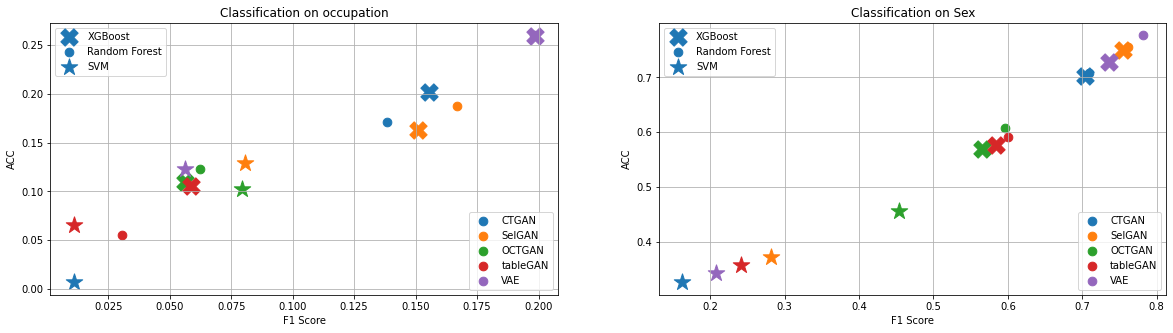

In [223]:
fig, ax = plt.subplots(1,2,figsize = (20,5))

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

xgb_ctgan = ax[0].scatter(o_f1["XGB"]["CTGAN"], o_acc["XGB"]["CTGAN"], marker='X', color=colors[0],s = 300)
rf_ctgan = ax[0].scatter(o_f1["RF"]["CTGAN"], o_acc["RF"]["CTGAN"], marker='.', color=colors[0],s = 300,label = "CTGAN")
svm_ctgan = ax[0].scatter(o_f1["SVM"]["CTGAN"], o_acc["SVM"]["CTGAN"], marker='*', color=colors[0],s = 300)

xgb_selgan = ax[0].scatter(o_f1["XGB"]["Selgan"], o_acc["XGB"]["Selgan"], marker='X', color=colors[1],s = 300)
rf_selgan = ax[0].scatter(o_f1["RF"]["Selgan"], o_acc["RF"]["Selgan"], marker='.', color=colors[1],s = 300,label = "SelGAN")
svm_selgan = ax[0].scatter(o_f1["SVM"]["Selgan"], o_acc["SVM"]["Selgan"], marker='*', color=colors[1],s = 300)

xgb_octgan = ax[0].scatter(o_f1["XGB"]["octgan"], o_acc["XGB"]["octgan"], marker='X', color=colors[2],s = 300)
rf_octgan = ax[0].scatter(o_f1["RF"]["octgan"], o_acc["RF"]["octgan"], marker='.', color=colors[2],s = 300,label = "OCTGAN")
svm_octgan = ax[0].scatter(o_f1["SVM"]["octgan"], o_acc["SVM"]["octgan"], marker='*', color=colors[2],s = 300)

xgb_tablegan = ax[0].scatter(o_f1["XGB"]["tablegan"], o_acc["XGB"]["tablegan"], marker='X', color=colors[3],s = 300)
rf_tablegan = ax[0].scatter(o_f1["RF"]["tablegan"], o_acc["RF"]["tablegan"], marker='.', color=colors[3],s = 300,label = "tableGAN")
svm_tablegan = ax[0].scatter(o_f1["SVM"]["tablegan"], o_acc["SVM"]["tablegan"], marker='*', color=colors[3],s = 300)

xgb_vae = ax[0].scatter(o_f1["XGB"]["VAE"], o_acc["XGB"]["VAE"], marker='X', color=colors[4],s = 300)
rf_vae = ax[0].scatter(o_f1["RF"]["VAE"], o_acc["RF"]["VAE"], marker='.', color=colors[4],s = 300,label = "VAE")
svm_vae = ax[0].scatter(o_f1["SVM"]["VAE"], o_acc["SVM"]["VAE"], marker='*', color=colors[4],s = 300)

ax[0].grid()
#plt.legend()
le1 = ax[0].legend((rf_ctgan, rf_selgan, rf_octgan, rf_tablegan, rf_vae),
           ('CTGAN', 'SelGAN', 'OCTGAN', 'tableGAN', 'VAE'),
           loc='lower right')
ax[0].add_artist(le1)

le2 = ax[0].legend((xgb_ctgan, rf_ctgan,svm_ctgan),
           ('XGBoost', 'Random Forest',"SVM"),
           loc='upper left')
ax[0].set_xlabel("F1 Score")
ax[0].set_ylabel("ACC")
ax[0].set_title("Classification on occupation")


xgb_ctgan = ax[1].scatter(sex_f1["XGB"]["CTGAN"], sex_acc["XGB"]["CTGAN"], marker='X', color=colors[0],s = 300)
rf_ctgan = ax[1].scatter(sex_f1["RF"]["CTGAN"], sex_acc["RF"]["CTGAN"], marker='.', color=colors[0],s = 300,label = "CTGAN")
svm_ctgan = ax[1].scatter(sex_f1["SVM"]["CTGAN"], sex_acc["SVM"]["CTGAN"], marker='*', color=colors[0],s = 300)

xgb_selgan = ax[1].scatter(sex_f1["XGB"]["Selgan"], sex_acc["XGB"]["Selgan"], marker='X', color=colors[1],s = 300)
rf_selgan = ax[1].scatter(sex_f1["RF"]["Selgan"], sex_acc["RF"]["Selgan"], marker='.', color=colors[1],s = 300,label = "SelGAN")
svm_selgan = ax[1].scatter(sex_f1["SVM"]["Selgan"], sex_acc["SVM"]["Selgan"], marker='*', color=colors[1],s = 300)

xgb_octgan = ax[1].scatter(sex_f1["XGB"]["octgan"], sex_acc["XGB"]["octgan"], marker='X', color=colors[2],s = 300)
rf_octgan = ax[1].scatter(sex_f1["RF"]["octgan"], sex_acc["RF"]["octgan"], marker='.', color=colors[2],s = 300,label = "OCTGAN")
svm_octgan = ax[1].scatter(sex_f1["SVM"]["octgan"], sex_acc["SVM"]["octgan"], marker='*', color=colors[2],s = 300)

xgb_tablegan = ax[1].scatter(sex_f1["XGB"]["tablegan"], sex_acc["XGB"]["tablegan"], marker='X', color=colors[3],s = 300)
rf_tablegan = ax[1].scatter(sex_f1["RF"]["tablegan"], sex_acc["RF"]["tablegan"], marker='.', color=colors[3],s = 300,label = "tableGAN")
svm_tablegan = ax[1].scatter(sex_f1["SVM"]["tablegan"], sex_acc["SVM"]["tablegan"], marker='*', color=colors[3],s = 300)

xgb_vae = ax[1].scatter(sex_f1["XGB"]["VAE"], sex_acc["XGB"]["VAE"], marker='X', color=colors[4],s = 300)
rf_vae = ax[1].scatter(sex_f1["RF"]["VAE"], sex_acc["RF"]["VAE"], marker='.', color=colors[4],s = 300,label = "VAE")
svm_vae = ax[1].scatter(sex_f1["SVM"]["VAE"], sex_acc["SVM"]["VAE"], marker='*', color=colors[4],s = 300)

ax[1].grid()
#plt.legend()
le1 = ax[1].legend((rf_ctgan, rf_selgan, rf_octgan, rf_tablegan, rf_vae),
           ('CTGAN', 'SelGAN', 'OCTGAN', 'tableGAN', 'VAE'),
           loc='lower right')
ax[1].add_artist(le1)

le2 = ax[1].legend((xgb_ctgan, rf_ctgan,svm_ctgan),
           ('XGBoost', 'Random Forest',"SVM"),
           loc='upper left')
ax[1].set_xlabel("F1 Score")
ax[1].set_ylabel("ACC")
ax[1].set_title("Classification on Sex")

plt.savefig("evaluation_result/{}/clf_{}.png".format(dataname,"adult"))
plt.show()

In [48]:
edu_num_r2_xgb, edu_num_mse_xgb = make_prediction("education-num", "reg",training_data, test,dataset,xgb_reg)
edu_num_r2_rf, edu_num_mse_rf = make_prediction("education-num", "reg",training_data, test,dataset,rf_reg)
edu_num_r2_svm, edu_num_mse_svm = make_prediction("education-num", "reg",training_data, test,dataset,svm_reg)

100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


In [49]:
edu_num = pd.DataFrame({"XGB":edu_num_mse_xgb,"RF":edu_num_mse_rf,"SVM":edu_num_mse_svm},index = ["Origin","CTGAN","Selgan","octgan","tablegan","VAE"])
edu_num["avg"] = edu_num.mean(axis=1)
edu_num

,XGB,RF,SVM,avg
Origin,0.000546,0.005140,12.531269,4.178985
CTGAN,6.303618,6.358057,10.323237,7.661637
Selgan,3.553827,4.039648,7.965186,5.186220
octgan,7.289854,7.090541,13.770430,9.383608
tablegan,10.656078,9.455976,51.832494,23.981516
VAE,5.991391,5.975121,37.330121,16.432211


In [2]:
edu_num

NameError: name 'edu_num' is not defined

In [1]:
edu_num.to_csv("adult_edunum_mse.csv")

NameError: name 'edu_num' is not defined

In [125]:
sex_f1_d = sex_f1.copy()
sex_f1_d.iloc[1] = abs(sex_f1.iloc[1].subtract(sex_f1.iloc[0]))
sex_f1_d.iloc[2] = abs(sex_f1.iloc[2].subtract(sex_f1.iloc[0]))
sex_f1_d.iloc[3] = abs(sex_f1.iloc[3].subtract(sex_f1.iloc[0]))
sex_f1_d.iloc[4] = abs(sex_f1.iloc[4].subtract(sex_f1.iloc[0]))
sex_f1_d.iloc[5] = abs(sex_f1.iloc[5].subtract(sex_f1.iloc[0]))


In [128]:
sex_auc_d = sex_auc.copy()
sex_auc_d.iloc[1] = abs(sex_auc.iloc[1].subtract(sex_auc.iloc[0]))
sex_auc_d.iloc[2] = abs(sex_auc.iloc[2].subtract(sex_auc.iloc[0]))
sex_auc_d.iloc[3] = abs(sex_auc.iloc[3].subtract(sex_auc.iloc[0]))
sex_auc_d.iloc[4] = abs(sex_auc.iloc[4].subtract(sex_auc.iloc[0]))
sex_auc_d.iloc[5] = abs(sex_auc.iloc[5].subtract(sex_auc.iloc[0]))


In [123]:
sex_f1_d.iloc[1] = abs(sex_f1.iloc[1].subtract(sex_f1.iloc[0]))

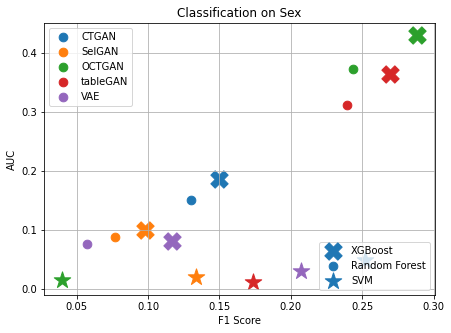

In [135]:
fig, ax = plt.subplots(figsize = (7,5))

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

xgb_ctgan = ax.scatter(sex_f1_d["XGB"]["CTGAN"], sex_auc_d["XGB"]["CTGAN"], marker='X', color=colors[0],s = 300)
rf_ctgan = ax.scatter(sex_f1_d["RF"]["CTGAN"], sex_auc_d["RF"]["CTGAN"], marker='.', color=colors[0],s = 300,label = "CTGAN")
svm_ctgan = ax.scatter(sex_f1_d["SVM"]["CTGAN"], sex_auc_d["SVM"]["CTGAN"], marker='*', color=colors[0],s = 300)

xgb_selgan = ax.scatter(sex_f1_d["XGB"]["Selgan"], sex_auc_d["XGB"]["Selgan"], marker='X', color=colors[1],s = 300)
rf_selgan = ax.scatter(sex_f1_d["RF"]["Selgan"], sex_auc_d["RF"]["Selgan"], marker='.', color=colors[1],s = 300,label = "SelGAN")
svm_selgan = ax.scatter(sex_f1_d["SVM"]["Selgan"], sex_auc_d["SVM"]["Selgan"], marker='*', color=colors[1],s = 300)

xgb_octgan = ax.scatter(sex_f1_d["XGB"]["octgan"], sex_auc_d["XGB"]["octgan"], marker='X', color=colors[2],s = 300)
rf_octgan = ax.scatter(sex_f1_d["RF"]["octgan"], sex_auc_d["RF"]["octgan"], marker='.', color=colors[2],s = 300,label = "OCTGAN")
svm_octgan = ax.scatter(sex_f1_d["SVM"]["octgan"], sex_auc_d["SVM"]["octgan"], marker='*', color=colors[2],s = 300)

xgb_tablegan = ax.scatter(sex_f1_d["XGB"]["tablegan"], sex_auc_d["XGB"]["tablegan"], marker='X', color=colors[3],s = 300)
rf_tablegan = ax.scatter(sex_f1_d["RF"]["tablegan"], sex_auc_d["RF"]["tablegan"], marker='.', color=colors[3],s = 300,label = "tableGAN")
svm_tablegan = ax.scatter(sex_f1_d["SVM"]["tablegan"], sex_auc_d["SVM"]["tablegan"], marker='*', color=colors[3],s = 300)

xgb_vae = ax.scatter(sex_f1_d["XGB"]["VAE"], sex_auc_d["XGB"]["VAE"], marker='X', color=colors[4],s = 300)
rf_vae = ax.scatter(sex_f1_d["RF"]["VAE"], sex_auc_d["RF"]["VAE"], marker='.', color=colors[4],s = 300,label = "VAE")
svm_vae = ax.scatter(sex_f1_d["SVM"]["VAE"], sex_auc_d["SVM"]["VAE"], marker='*', color=colors[4],s = 300)

ax.grid()
#plt.legend()
le1 = ax.legend((rf_ctgan, rf_selgan, rf_octgan, rf_tablegan, rf_vae),
           ('CTGAN', 'SelGAN', 'OCTGAN', 'tableGAN', 'VAE'),
           loc='upper left')
ax.add_artist(le1)

le2 = ax.legend((xgb_ctgan, rf_ctgan,svm_ctgan),
           ('XGBoost', 'Random Forest',"SVM"),
           loc='lower right')
ax.set_xlabel("F1 Score")
ax.set_ylabel("AUC")
ax.set_title("Classification on Sex")
plt.show()

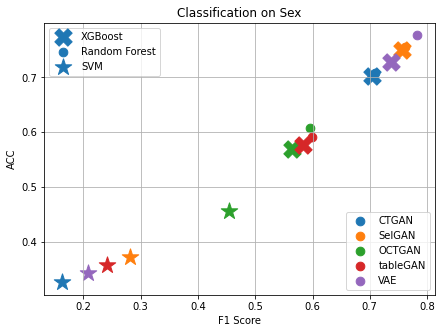

In [171]:
import matplotlib.pyplot as plt
from numpy.random import random

fig, ax = plt.subplots(figsize = (7,5))

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

xgb_ctgan = ax.scatter(sex_f1["XGB"]["CTGAN"], sex_acc["XGB"]["CTGAN"], marker='X', color=colors[0],s = 300)
rf_ctgan = ax.scatter(sex_f1["RF"]["CTGAN"], sex_acc["RF"]["CTGAN"], marker='.', color=colors[0],s = 300,label = "CTGAN")
svm_ctgan = ax.scatter(sex_f1["SVM"]["CTGAN"], sex_acc["SVM"]["CTGAN"], marker='*', color=colors[0],s = 300)

xgb_selgan = ax.scatter(sex_f1["XGB"]["Selgan"], sex_acc["XGB"]["Selgan"], marker='X', color=colors[1],s = 300)
rf_selgan = ax.scatter(sex_f1["RF"]["Selgan"], sex_acc["RF"]["Selgan"], marker='.', color=colors[1],s = 300,label = "SelGAN")
svm_selgan = ax.scatter(sex_f1["SVM"]["Selgan"], sex_acc["SVM"]["Selgan"], marker='*', color=colors[1],s = 300)

xgb_octgan = ax.scatter(sex_f1["XGB"]["octgan"], sex_acc["XGB"]["octgan"], marker='X', color=colors[2],s = 300)
rf_octgan = ax.scatter(sex_f1["RF"]["octgan"], sex_acc["RF"]["octgan"], marker='.', color=colors[2],s = 300,label = "OCTGAN")
svm_octgan = ax.scatter(sex_f1["SVM"]["octgan"], sex_acc["SVM"]["octgan"], marker='*', color=colors[2],s = 300)

xgb_tablegan = ax.scatter(sex_f1["XGB"]["tablegan"], sex_acc["XGB"]["tablegan"], marker='X', color=colors[3],s = 300)
rf_tablegan = ax.scatter(sex_f1["RF"]["tablegan"], sex_acc["RF"]["tablegan"], marker='.', color=colors[3],s = 300,label = "tableGAN")
svm_tablegan = ax.scatter(sex_f1["SVM"]["tablegan"], sex_acc["SVM"]["tablegan"], marker='*', color=colors[3],s = 300)

xgb_vae = ax.scatter(sex_f1["XGB"]["VAE"], sex_acc["XGB"]["VAE"], marker='X', color=colors[4],s = 300)
rf_vae = ax.scatter(sex_f1["RF"]["VAE"], sex_acc["RF"]["VAE"], marker='.', color=colors[4],s = 300,label = "VAE")
svm_vae = ax.scatter(sex_f1["SVM"]["VAE"], sex_acc["SVM"]["VAE"], marker='*', color=colors[4],s = 300)

ax.grid()
#plt.legend()
le1 = ax.legend((rf_ctgan, rf_selgan, rf_octgan, rf_tablegan, rf_vae),
           ('CTGAN', 'SelGAN', 'OCTGAN', 'tableGAN', 'VAE'),
           loc='lower right')
ax.add_artist(le1)

le2 = ax.legend((xgb_ctgan, rf_ctgan,svm_ctgan),
           ('XGBoost', 'Random Forest',"SVM"),
           loc='upper left')
ax.set_xlabel("F1 Score")
ax.set_ylabel("ACC")
ax.set_title("Classification on Sex")
plt.savefig("evaluation_result/{}/clf_{}.png".format(dataname,"sex"))
plt.show()

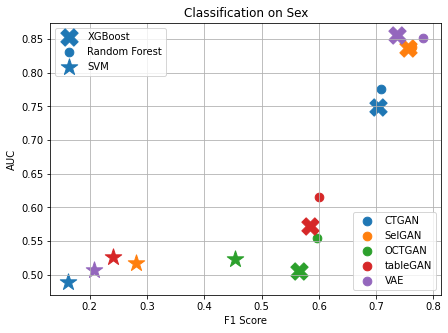

In [180]:
import matplotlib.pyplot as plt
from numpy.random import random

fig, ax = plt.subplots(figsize = (7,5))

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

xgb_ctgan = ax.scatter(sex_f1["XGB"]["CTGAN"], sex_auc["XGB"]["CTGAN"], marker='X', color=colors[0],s = 300)
rf_ctgan = ax.scatter(sex_f1["RF"]["CTGAN"], sex_auc["RF"]["CTGAN"], marker='.', color=colors[0],s = 300,label = "CTGAN")
svm_ctgan = ax.scatter(sex_f1["SVM"]["CTGAN"], sex_auc["SVM"]["CTGAN"], marker='*', color=colors[0],s = 300)

xgb_selgan = ax.scatter(sex_f1["XGB"]["Selgan"], sex_auc["XGB"]["Selgan"], marker='X', color=colors[1],s = 300)
rf_selgan = ax.scatter(sex_f1["RF"]["Selgan"], sex_auc["RF"]["Selgan"], marker='.', color=colors[1],s = 300,label = "SelGAN")
svm_selgan = ax.scatter(sex_f1["SVM"]["Selgan"], sex_auc["SVM"]["Selgan"], marker='*', color=colors[1],s = 300)

xgb_octgan = ax.scatter(sex_f1["XGB"]["octgan"], sex_auc["XGB"]["octgan"], marker='X', color=colors[2],s = 300)
rf_octgan = ax.scatter(sex_f1["RF"]["octgan"], sex_auc["RF"]["octgan"], marker='.', color=colors[2],s = 300,label = "OCTGAN")
svm_octgan = ax.scatter(sex_f1["SVM"]["octgan"], sex_auc["SVM"]["octgan"], marker='*', color=colors[2],s = 300)

xgb_tablegan = ax.scatter(sex_f1["XGB"]["tablegan"], sex_auc["XGB"]["tablegan"], marker='X', color=colors[3],s = 300)
rf_tablegan = ax.scatter(sex_f1["RF"]["tablegan"], sex_auc["RF"]["tablegan"], marker='.', color=colors[3],s = 300,label = "tableGAN")
svm_tablegan = ax.scatter(sex_f1["SVM"]["tablegan"], sex_auc["SVM"]["tablegan"], marker='*', color=colors[3],s = 300)

xgb_vae = ax.scatter(sex_f1["XGB"]["VAE"], sex_auc["XGB"]["VAE"], marker='X', color=colors[4],s = 300)
rf_vae = ax.scatter(sex_f1["RF"]["VAE"], sex_auc["RF"]["VAE"], marker='.', color=colors[4],s = 300,label = "VAE")
svm_vae = ax.scatter(sex_f1["SVM"]["VAE"], sex_auc["SVM"]["VAE"], marker='*', color=colors[4],s = 300)

ax.grid()
#plt.legend()
le1 = ax.legend((rf_ctgan, rf_selgan, rf_octgan, rf_tablegan, rf_vae),
           ('CTGAN', 'SelGAN', 'OCTGAN', 'tableGAN', 'VAE'),
           loc='lower right')
ax.add_artist(le1)

le2 = ax.legend((xgb_ctgan, rf_ctgan,svm_ctgan),
           ('XGBoost', 'Random Forest',"SVM"),
           loc='upper left')
ax.set_xlabel("F1 Score")
ax.set_ylabel("AUC")
ax.set_title("Classification on Sex")
plt.savefig("evaluation_result/{}/clf_{}.png".format(dataname,"sex"))
plt.show()


In [ ]:
ct

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,label
0,23.0,2,370864.0,15,10.0,4,0,2,1,0,-15.0,-4.0,34.0,17,0,ctgan
1,26.0,2,45546.0,11,13.0,4,7,4,0,0,-9.0,1.0,14.0,37,0,ctgan
2,54.0,2,293758.0,12,15.0,5,6,0,2,1,-33.0,3.0,40.0,24,0,ctgan
3,46.0,1,291516.0,11,10.0,6,5,0,4,0,36.0,-2.0,54.0,37,0,ctgan
4,23.0,2,215345.0,11,9.0,2,11,3,4,1,-57.0,-2.0,40.0,24,0,ctgan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30143,32.0,3,210409.0,11,12.0,2,9,0,4,1,31.0,1.0,50.0,37,0,ctgan
30144,33.0,4,278420.0,9,14.0,2,2,5,4,1,0.0,0.0,40.0,37,0,ctgan
30145,61.0,2,161391.0,11,10.0,5,2,4,4,1,-71.0,2.0,15.0,31,0,ctgan
30146,19.0,2,221536.0,9,10.0,4,9,0,4,1,-23.0,-2.0,40.0,37,0,ctgan


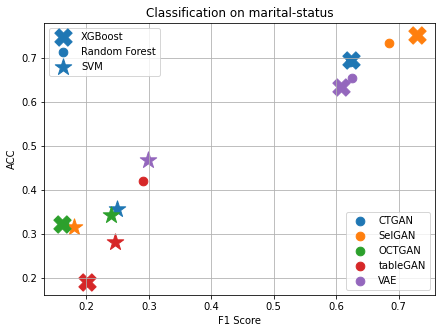

In [202]:
fig, ax = plt.subplots(figsize = (7,5))

xgb_ctgan = ax.scatter(ms_f1["XGB"]["CTGAN"], ms_acc["XGB"]["CTGAN"], marker='X', color=colors[0],s = 300)
rf_ctgan = ax.scatter(ms_f1["RF"]["CTGAN"], ms_acc["RF"]["CTGAN"], marker='.', color=colors[0],s = 300,label = "CTGAN")
svm_ctgan = ax.scatter(ms_f1["SVM"]["CTGAN"], ms_acc["SVM"]["CTGAN"], marker='*', color=colors[0],s = 300)

xgb_selgan = ax.scatter(ms_f1["XGB"]["Selgan"], ms_acc["XGB"]["Selgan"], marker='X', color=colors[1],s = 300)
rf_selgan = ax.scatter(ms_f1["RF"]["Selgan"], ms_acc["RF"]["Selgan"], marker='.', color=colors[1],s = 300,label = "SelGAN")
svm_selgan = ax.scatter(ms_f1["SVM"]["Selgan"], ms_acc["SVM"]["Selgan"], marker='*', color=colors[1],s = 300)

xgb_octgan = ax.scatter(ms_f1["XGB"]["octgan"], ms_acc["XGB"]["octgan"], marker='X', color=colors[2],s = 300)
rf_octgan = ax.scatter(ms_f1["RF"]["octgan"], ms_acc["RF"]["octgan"], marker='.', color=colors[2],s = 300,label = "OCTGAN")
svm_octgan = ax.scatter(ms_f1["SVM"]["octgan"], ms_acc["SVM"]["octgan"], marker='*', color=colors[2],s = 300)

xgb_tablegan = ax.scatter(ms_f1["XGB"]["tablegan"], ms_acc["XGB"]["tablegan"], marker='X', color=colors[3],s = 300)
rf_tablegan = ax.scatter(ms_f1["RF"]["tablegan"], ms_acc["RF"]["tablegan"], marker='.', color=colors[3],s = 300,label = "tableGAN")
svm_tablegan = ax.scatter(ms_f1["SVM"]["tablegan"], ms_acc["SVM"]["tablegan"], marker='*', color=colors[3],s = 300)

xgb_vae = ax.scatter(ms_f1["XGB"]["VAE"], ms_acc["XGB"]["VAE"], marker='X', color=colors[4],s = 300)
rf_vae = ax.scatter(ms_f1["RF"]["VAE"], ms_acc["RF"]["VAE"], marker='.', color=colors[4],s = 300,label = "VAE")
svm_vae = ax.scatter(ms_f1["SVM"]["VAE"], ms_acc["SVM"]["VAE"], marker='*', color=colors[4],s = 300)

ax.grid()
#plt.legend()
le1 = ax.legend((rf_ctgan, rf_selgan, rf_octgan, rf_tablegan, rf_vae),
           ('CTGAN', 'SelGAN', 'OCTGAN', 'tableGAN', 'VAE'),
           loc='lower right')
ax.add_artist(le1)

le2 = ax.legend((xgb_ctgan, rf_ctgan,svm_ctgan),
           ('XGBoost', 'Random Forest',"SVM"),
           loc='upper left')
ax.set_xlabel("F1 Score")
ax.set_ylabel("ACC")
ax.set_title("Classification on marital-status")
plt.savefig("evaluation_result/{}/clf_{}.png".format(dataname,"ms"))
plt.show()

In [177]:
ms_f1

,XGB,RF,SVM,avg
Origin,0.830906,0.822840,0.286258,0.646668
CTGAN,0.622998,0.622316,0.059175,0.434829
Selgan,0.729238,0.660829,0.197104,0.529057
octgan,0.160792,0.164581,0.002593,0.109322
tablegan,0.201144,0.303484,0.087478,0.197369
VAE,0.608067,0.625229,0.314595,0.515964


In [132]:
make_prediction("education", "clf",training_data, test,dataset)

100%|██████████| 5/5 [01:05<00:00, 13.02s/it]


([1.0,
  0.35006634232640427,
  0.5872401592215833,
  0.20212295444493586,
  0.006855373728438744,
  0.5026536930561698],
 [1.0,
  0.22589487756724286,
  0.5352616266092072,
  0.18014651248842367,
  0.0014490670098935058,
  0.34730858932369635])

In [140]:
make_prediction("capital-loss", "reg",training_data, test,dataset)

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


[165610.64589546353,
 166451.02491770237,
 194572.63932275822,
 166491.6220234039,
 234897.5370403336,
 184783.36326203105]

In [139]:
make_prediction("hours-per-week", "reg",training_data, test,dataset)

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


[108.16680295187327,
 143.05354597477339,
 148.13538023959575,
 208.04594414384738,
 409.43378033039886,
 149.15008302031853]

In [137]:
make_prediction("education-num", "reg",training_data, test,dataset)

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


[0.003974168196389847,
 6.186706885291035,
 3.8204408183816456,
 7.20330760033567,
 9.548539979657487,
 5.908915706613958]

In [131]:
make_prediction("education", "reg",training_data, test,dataset)

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


[4.315685507955905e-10,
 14.796763007687902,
 9.421108340312825,
 20.17345432304931,
 91.00006488159366,
 14.895680269314077]

its:7 col
full:7 col

In [41]:
def make_clustering(training_data,test,dataset,n = 5):
    NMI = []

    train_data_x = training_data.drop(columns=["income"]).astype("float64")

    test_data_X = test.drop(columns=["income"]).astype("float64")
    
    kmeans = KMeans(n_clusters=n).fit(train_data_x)

    ground_truth = kmeans.predict(test_data_X)

    NMI.append(normalized_mutual_info_score(ground_truth, ground_truth))
    #print(train_data_x.columns)

    for data in dataset:
        data = data.drop(columns=["label","income"]).astype("float64")
        #print(data.columns)
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        result = kmeans.predict(test_data_X)
        NMI.append(normalized_mutual_info_score(ground_truth, result))




    return NMI
### Clustering

In [44]:
## Unsupervised Machine learning task 
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
pd.DataFrame(make_clustering(training_data,test,dataset,n=5),index=["ground Truth",'ctgan','selgan',"octgan","tablegan",'VAE',"daisy","daisy_sel","daisy_sm"],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
ctgan,0.838986
selgan,0.771245
octgan,0.756478
tablegan,0.700475
VAE,0.577308
daisy,0.868555
daisy_sel,0.798423
daisy_sm,0.566305


In [35]:
dataset = [ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]

### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [ ]:
len(dataset)

In [ ]:
similar = hitting_rate(dataset)

In [ ]:
maxi,mini = DCR(dataset)


In [ ]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its","Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])